# Pursuer Model

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set device
print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

3.9.5 (default, May 11 2021, 08:20:37) 
[GCC 10.3.0]
1.9.1+cu111
11.1
cuda


## Load train and test data set

In [2]:
sel_env = 4
res = 2

batch_size = 256

# data loading
states_actions = pd.read_csv('./train_set_Env'+str(sel_env)+'_res'+str(res)+'.csv', dtype=np.float32)
states_actions = states_actions.sample(frac = 1).reset_index(drop = True)

total_samples = states_actions.shape[0]
total_train_samples = int(0.8*total_samples)
total_test_samples = total_samples - total_train_samples

states_actions_train = states_actions.iloc[:total_train_samples,:]
states_actions_test = states_actions.iloc[(total_train_samples+1):,:]

print('Total samples:', total_samples)
print('Train samples:', total_train_samples)
print('Test samples:', total_test_samples)

Total samples: 69620
Train samples: 55696
Test samples: 13924


### Check Actions distributions

Pursuer discrete actions distribution percentage
Action 0 (stay): 22.72
        Action 1 (move right): 19.35
        Action 2 (move up): 17.93
        Action 3 (move left): 21.18
        Action 4 (move down): 18.81


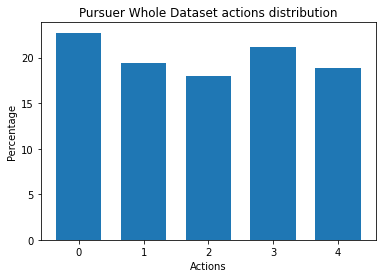

In [3]:
action_0 = sum(states_actions.iloc[:,5] == 0.0)
action_1 = sum(states_actions.iloc[:,5] == 1.0)
action_2 = sum(states_actions.iloc[:,5] == 2.0)
action_3 = sum(states_actions.iloc[:,5] == 3.0)
action_4 = sum(states_actions.iloc[:,5] == 4.0)

actions = np.array([action_0, action_1, action_2, action_3, action_4])
actions = actions/total_samples * 100.0

print('Pursuer discrete actions distribution percentage\nAction 0 (stay): {:.2f}\n\
        Action 1 (move right): {:.2f}\n\
        Action 2 (move up): {:.2f}\n\
        Action 3 (move left): {:.2f}\n\
        Action 4 (move down): {:.2f}'\
        .format(actions[0], actions[1], actions[2], actions[3], actions[4])
    )

plt.bar(np.linspace(0,4,5, endpoint = True), actions, width=0.7)
plt.xlabel('Actions')
plt.xticks(range(0,5))
plt.ylabel('Percentage')
plt.title('Pursuer Whole Dataset actions distribution')
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'_pursuer_distributions.png')
plt.show()

In [4]:
class PursuerTrainDataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(states_actions_train.iloc[:, 0:4].values)
        self.y = torch.from_numpy(states_actions_train.iloc[:, 5].values).long()
        self.n_samples = states_actions_train.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

train_set = PursuerTrainDataset()
train_loader = DataLoader(dataset = train_set, 
                          batch_size = batch_size, 
                          shuffle = False, 
                          num_workers = 2
                        )

class PursuerTestDataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(states_actions_test.iloc[:, 0:4].values)
        self.y = torch.from_numpy(states_actions_test.iloc[:, 5].values).long()
        self.n_samples = states_actions_test.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

test_set = PursuerTestDataset()
test_loader = DataLoader(dataset = test_set, 
                         batch_size = batch_size, 
                         shuffle = False, num_workers = 2
                        )

## Hyperparameters

In [5]:
input_size = 4
output_size = 5
learning_rate = 1e-3
epochs = 1000

## Create Fully Connected Network

In [6]:
from models import pursuer_NN

# Initialize network
pursuer_model = pursuer_NN(input_size, output_size, 256, device).to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(pursuer_model.parameters(), lr = learning_rate)

## Training

In [7]:
loss_list         = []
loss_val_list     = []
iteration_list    = []
accuracy_list     = []
accuracy_list_val = []
overfitting = False

i = 0
for epoch in range(epochs):
    total=0
    correct=0

    for batch_idx, (state, action) in enumerate(train_loader):
        state = state.to(device = device)
        action = action.to(device = device)

        state = Variable(state)
        action = Variable(action)

        # Forward
        outputs = pursuer_model.predict(state)
        loss_train = criterion(outputs, action)

        # Backward
        optimizer.zero_grad()
        loss_train.backward()

        # Gradient decent
        optimizer.step()

        predicted = torch.max(outputs.data, 1)[1]
        total += len(action)
        correct += (predicted == action).sum()
    
    # calcula el desempeño en entrenamiento: Precisión (accuracy)
    accuracy = float(correct) / float(total)
    # almacena la evaluación de desempeño
    iteration_list.append(epoch)
    loss_list.append(loss_train.item())
    accuracy_list.append(accuracy)



    # Evaluate prediction by lots on each epoch
    correct = 0
    total   = 0
    for state, action in test_loader:
        state = state.to(device = device)
        action = action.to(device = device)

        state = Variable(state)
        action = Variable(action)

        outputs = pursuer_model.predict(state)
        loss_val = criterion(outputs, action)

        predicted = torch.max(outputs.data, 1)[1]   # etiqueta predicha (WTA)  
        total += len(action)                        # número total de etiquetas en lote
        correct += (predicted == action).sum() 
        
    accuracy_val = float(correct) / float(total)
    loss_val_list.append(loss_val.item())
    accuracy_list_val.append(accuracy_val)

    # - - - - - - - - - - - - - - - 
    # Display evaluación
    # - - - - - - - - - - - - - - - 
    if i%5 == 0 or i == epochs-1:
        print('\rEpoch: {:02}  Loss: {:.4f}  Loss Val: {:.4f}  Accuracy: {:.4f}  Accuracy Val: {:.4f}'\
            .format(epoch, loss_train.data, loss_val.data, accuracy, accuracy_val), end=''
            )
    i+=1
    # Condition to early stop
    # N = 50
    # epsilon = 0.001
    # if epoch > N:
    #     accuracy_mean = np.mean(accuracy_list[-N:])
    #     accuracy_val_mean = np.mean(accuracy_list_val[-N:])

    #     # if accuracy_val_mean > accuracy_mean:
    #     #     overfitting = True

    #     # if accuracy_mean > accuracy_val_mean and overfitting:
    #     #     print('Epoch used:', epoch)
    #     #     break
    #     if accuracy_val - accuracy_val_mean < epsilon:
    #         print('Epoch used:', epoch)
    #         break

Epoch: 999  Loss: 0.9857  Loss Val: 0.9921  Accuracy: 0.9230  Accuracy Val: 0.8950

In [8]:
print('{:.4f}'.format(loss_list[-1]))
print('{:.4f}'.format(loss_val_list[-1]))

print('{:.2f}'.format(100*accuracy_list[-1]))
print('{:.2f}'.format(100*accuracy_list_val[-1]))

0.9857
0.9921
92.30
89.50


## Results Visualization

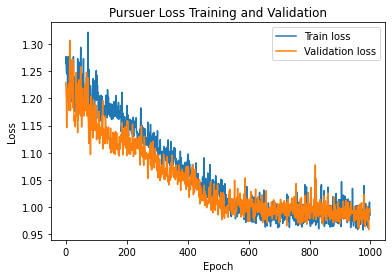

In [9]:
# Loss
plt.plot(iteration_list,loss_list)
plt.plot(iteration_list,loss_val_list)
plt.legend(['Train loss', 'Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pursuer Loss Training and Validation")
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'_pursuer_loss.png')
plt.show()

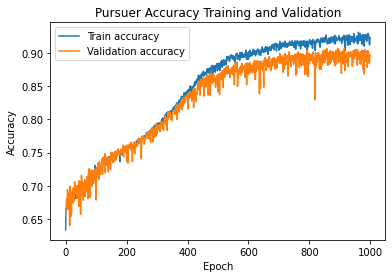

In [10]:
# Accuracy
plt.plot(iteration_list,accuracy_list)
plt.plot(iteration_list,accuracy_list_val)
plt.legend(['Train accuracy', 'Validation accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Pursuer Accuracy Training and Validation")
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'_pursuer_accuracy.png')
plt.show()

## Save the model

In [11]:
torch.save(pursuer_model, 'pursuer_NN_Env' + str(sel_env) + '_res' + str(res) + '.pt')
torch.save(pursuer_model.state_dict(), 'pursuer_dict_NN_Env' + str(sel_env) + '_res' + str(res) + '.pt')